In [ ]:
#Importing the libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
from torchvision import datasets,models
from tqdm import tqdm
from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tqdm import tqdm

In [ ]:
#From HW 4
class IndexedDataset(Dataset):

    def __init__(self, dir_path):
        self.dir_path = dir_path
        
        if os.path.basename(self.dir_path) == 'train': #transforms for the train dataset
          self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        ])
        elif os.path.basename(self.dir_path) == 'test': #transforms for the test dataset
          self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        ])
        
        image_filenames = []
        for (dirpath, dirnames, filenames) in os.walk(dir_path): #Saving all the image locations
            image_filenames += [os.path.join(dirpath, file) for file in filenames]
        self.image_filenames = image_filenames    
        self.labels_map = {"airplane" : 0, "bus": 1, "cat" : 2, "dog" : 3, "pizza" : 4} #Creating hashmap of the class and a number

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        return image, self.labels_map[os.path.basename(os.path.dirname(img_name))]


In [ ]:
#Converts the images to patches
class Patch_Embedding(nn.Module):
    def __init__(self,in_channels=3,embedding_size=768,patch_size=16,img_size=224):
        #Assuming that the image size is perfectly divisible by patch_size
        super().__init__()
        self.embedding_size = embedding_size
        self.num_patches = (img_size//patch_size)**2 #(h*w)/patch_size**2
        self.conv = nn.Conv2d(in_channels,embedding_size,patch_size,stride=patch_size) #Divides up the images into patches
        self.cls = nn.Parameter(torch.randn((1,embedding_size))) #The cls token
        self.pos = nn.Parameter(torch.randn((self.num_patches+1,embedding_size))) #Position embedding     
         
    def forward(self,x):
        # x is of shape (b,c,h,w)
        batch_size = x.shape[0]
        y = self.conv(x) #y is of shape (b,embedding_size,h/patch_size,w/patch_size)
        out = y.view(-1,self.embedding_size,self.num_patches) #out is of shape (b,embedding_size,(h*w)/patch_size**2)
        out = torch.permute(out,(0,2,1)) #out is of shape (b,num_patches,embedding_size)
        
        #Appending the cls token
        cout = torch.concat((out,self.cls.repeat(batch_size,1,1)),1) #cout is of shape (b,num_patches+1,embedding_size)
        
        #Adding the position embedding
        pcout = cout+self.pos.repeat(batch_size,1,1)  #pcout is of shape (b,num_patches+1,embedding_size)
        
        return pcout

In [ ]:
#Final classification head
class ClassificationHead(nn.Module):
    def __init__(self,embedding_size=768,num_classes=5):
        super().__init__()
        self.fc = nn.Linear(embedding_size,num_classes)
    
    def forward(self,x):
        #x is of shape (b,num_patches,embedding_size)
        x = x[:,-1,:] #Taking the output of the last patch
        out = self.fc(x)
        return out

In [ ]:
#Main attention implementation
class MultiAttentionhead(nn.Module):
    def __init__(self,embedding_size=768,num_heads=8,p=0.0):
        super().__init__()
        self.embedding_size = embedding_size #The embedding size of each 16x16 sized image patch
        self.num_heads = num_heads #Into how many parts the embedding is split into
        self.QKV = nn.Linear(embedding_size,3*embedding_size) #The learnable matrices for Query,Key and Value
        self.fc = nn.Linear(embedding_size,embedding_size) #To be applied at the output 
        self.drop = nn.Dropout(p) #'p' is Dropped out
        
    def forward(self,x):
        #x is of shape (b,num_patches,embedding_size)
        b = x.shape[0]
        num_patches = x.shape[1]
        
        #Getting the Q,K,V for every patch in all the batches
        QKV1 = self.QKV(x) #QKV1 is of shape (b,num_patches,3*embedding_size)
        QKV2 = QKV1.reshape(b,num_patches,self.num_heads,self.embedding_size//self.num_heads,3) #QKV2 is of shape 
                                                                                                #(b,num_patches,heads,embedding_size/heads,3)
                                                                                                
        Q,K,V = torch.permute(QKV2,(4,0,2,1,3)) #Q,K,V are of shape (b,heads,num_patches,embedding/heads)
        
        #Computing the attention
        QKT = torch.einsum('bhid,bhjd -> bhij',Q,K) #QKT is of shape (b,heads,num_patches,num_patches)
                                                    #This gives the relationship between each patch
            
        attention = F.softmax(QKT,dim=-1)/(self.embedding_size**(0.5)) #Softmax converts the relationship between one patch to 
                                                                       # to all the other patches into a pdf for all the patches
        attention = self.drop(attention)
        
        #Updating the value 
        QKtV = torch.einsum('bhik,bhkj -> bhij',QKT,V) #is of shape (b,heads,num_patches,embedding/heads)
        z = torch.permute(QKtV,(0,2,1,3)) #is of shape (b,num_patches,heads,embedding/heads)
        Z = z.reshape(b,num_patches,-1) #is of shape (b,num_patches,embedding_size)
        out = self.fc(Z) #is of shape (b,num_patches,embedding_size)
        return out
        
        
        

In [ ]:
#Multi layer perceptron at the end of every Transformer block
class MLP(nn.Module):
    #The MLP block within the transformer
    def __init__(self,embedding_size=768,p=0.0,expansion=4):
        super().__init__()
        self.fc1 = nn.Linear(embedding_size,expansion*embedding_size)
        self.fc2 = nn.Linear(expansion*embedding_size,embedding_size)
        self.gelu = nn.GELU()
        self.drop = nn.Dropout(p)
    
    def forward(self,x):  
        #x is of shape (b,num_patches,embedding_size)
        x = self.gelu(self.fc1(x))
        out = self.fc2(self.drop(x))
        return out

In [ ]:
#One transformer block
class Transformer(nn.Module):
    #The overall Transformer block
    def __init__(self,embedding_size=768,p=0.0,expansion=4,num_heads=8):
        super().__init__()
        self.ln1 = nn.LayerNorm(embedding_size)
        self.MAH = MultiAttentionhead(embedding_size,num_heads,p)
        self.ln2 = nn.LayerNorm(embedding_size)
        self.mlp = MLP(embedding_size,p,expansion)
        
    def forward(self,x):
        identity1 = x
        x = self.MAH(self.ln1(x))
        identity2 = x + identity1 #skip connection
        out = self.mlp(self.ln2(identity2))
        out = out + identity2 #skip connection
        return out
        

In [ ]:
#Overall ViT implementation
class ViT(nn.Module):
    def __init__(self,embedding_size=768,p=0.0,expansion=4,num_heads=8,in_channels=3,patch_size=16,img_size=224,num_classes=1000,depth=12):
        super().__init__()
        
        self.embedding = Patch_Embedding(in_channels,embedding_size,patch_size,img_size)
        
        Tlayers = [] #A ViT would have multiple (depth) Transformer blocks
        for i in range(depth):
            Tlayers.append(Transformer(embedding_size,p,expansion,num_heads))
        
        self.Tlayers = nn.Sequential(*Tlayers)
        
        self.head = ClassificationHead(embedding_size,num_classes)
        
    def forward(self,x):
        #Getting the embeddings of each patch of all the batch images
        x = self.embedding(x)
        
        #Passing them through "depth" Transformer blocks
        x = self.Tlayers(x)
        
        #Passing the output through classification head
        out = self.head(x)
        return out
        
        

In [ ]:
#Function to count the number of parameters from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
#Function to calculate the accuracy of the model 
def find_acc(net,dataloader):
  net.eval()
  correct = 0
  with torch.no_grad():
    loop = tqdm(dataloader)
    for i,data in enumerate(loop):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = net(inputs)
      predicted = torch.argmax(outputs,1)
      correct  = correct + torch.sum(predicted.cpu()==labels.cpu()).item()
  net.train()
  return (correct*100)/len(dataloader.dataset)


    

In [ ]:
#Funtion to train the model
def training(epochs,optimizer,criterion,net,train_data_loader,test_data_loader,device):
  train_losses = []
  train_accs = []
  test_accs = []
  for epoch in range(epochs):
    running_loss = 0.0
    loop = tqdm(train_data_loader)
    for i, data in enumerate(loop):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.cpu().item()
      loop.set_postfix(loss=running_loss/(i+1))

    train_acc = find_acc(net,train_data_loader)  
    test_acc = find_acc(net,test_data_loader)

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print("[epoch: %d] loss: %.3f Train Accuracy: %.3f Test Accuracy: %.3f " % (epoch + 1, running_loss/(i+1),train_acc,test_acc))
    print("\n")
    train_losses.append(running_loss/len(train_dataset))
  return net, train_losses, train_accs, test_accs 

In [ ]:
#Function to plot the confusion matrix 
def confusion_matrix(model,test_data_loader):
  matrix = torch.zeros((5,5))
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_data_loader):
      model.eval()                
      X_test, y_test = X_test.to(device), y_test.to(device)                
      # Apply the model                
      y_val = model(X_test)           
               
      # Tally the number of correct predictions
      predicted = torch.max(y_val.data, 1)[1] 
      for i in range(len(predicted)):
        matrix[predicted[i].cpu(),y_test[i].cpu()] += 1

  heat = pd.DataFrame(matrix, index = [i for i in ["airplane","bus","cat","dog","pizza"]],
                  columns = [i for i in ["airplane","bus","cat","dog","pizza"]])
  heat = heat.astype(int)
  accuracy = (matrix.trace()/matrix.sum())*100
  plt.figure(figsize = (10,7))
  plt.title("Total accuracy is "+str(accuracy.item()))
  s = sn.heatmap(heat, annot=True,cmap='Blues',fmt='g')
  s.set(xlabel='Ground Truth', ylabel='Predicted')
  
                


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_dataset = IndexedDataset("/content/drive/MyDrive/Dataset_HW4/train")
test_dataset = IndexedDataset("/content/drive/MyDrive/Dataset_HW4/test")
train_data_loader = DataLoader(train_dataset,batch_size=32, shuffle=True,num_workers=32)
test_data_loader = DataLoader(test_dataset,batch_size=32, shuffle=True,num_workers=32)

criterion = nn.CrossEntropyLoss()
epochs = 10

model = ViT(embedding_size=384,p=0.0,expansion=4,num_heads=64,in_channels=3,patch_size=16,img_size=64,num_classes=5,depth=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, betas = (0.9,0.99))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
count_parameters(model)

10950917

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

7500
2500


100%|██████████| 79/79 [01:15<00:00,  1.04it/s]


[epoch: 1] loss: 1.384 Train Accuracy: 57.120 Test Accuracy: 47.120 




100%|██████████| 79/79 [00:05<00:00, 13.29it/s]


[epoch: 2] loss: 1.050 Train Accuracy: 69.640 Test Accuracy: 51.720 




100%|██████████| 79/79 [00:06<00:00, 13.03it/s]


[epoch: 3] loss: 0.878 Train Accuracy: 76.427 Test Accuracy: 50.880 




100%|██████████| 79/79 [00:05<00:00, 13.17it/s]


[epoch: 4] loss: 0.732 Train Accuracy: 83.293 Test Accuracy: 52.120 




100%|██████████| 79/79 [00:06<00:00, 12.25it/s]


[epoch: 5] loss: 0.578 Train Accuracy: 89.440 Test Accuracy: 51.840 




100%|██████████| 79/79 [00:06<00:00, 13.05it/s]


[epoch: 6] loss: 0.435 Train Accuracy: 93.307 Test Accuracy: 50.960 




100%|██████████| 79/79 [00:06<00:00, 12.05it/s]


[epoch: 7] loss: 0.293 Train Accuracy: 95.267 Test Accuracy: 51.480 




100%|██████████| 79/79 [00:06<00:00, 13.07it/s]


[epoch: 8] loss: 0.215 Train Accuracy: 96.040 Test Accuracy: 47.800 




100%|██████████| 79/79 [00:07<00:00, 10.35it/s]


[epoch: 9] loss: 0.158 Train Accuracy: 97.427 Test Accuracy: 48.720 




100%|██████████| 79/79 [00:06<00:00, 12.88it/s]

[epoch: 10] loss: 0.144 Train Accuracy: 97.680 Test Accuracy: 50.560 




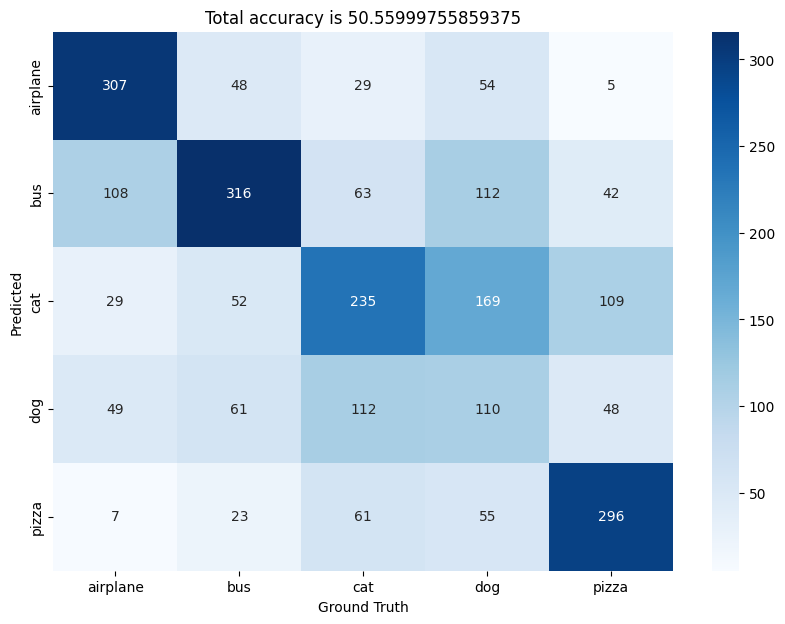

In [ ]:
trained_model,train_losses,train_accs, test_accs  = training(epochs,optimizer,criterion,model,train_data_loader,test_data_loader,device)
confusion_matrix(trained_model,test_data_loader) 

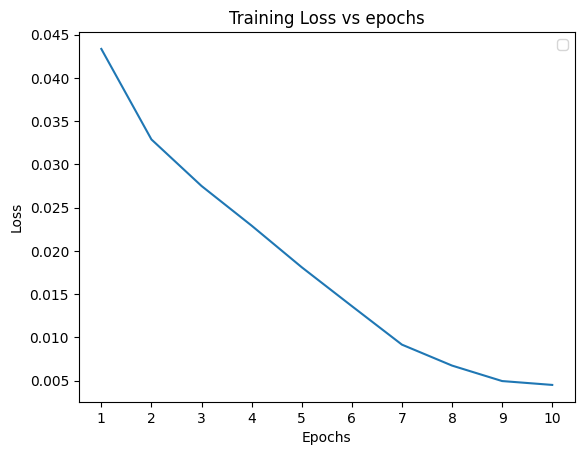

In [ ]:
epochs = np.arange(1,11)
plt.xticks(epochs, epochs)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs epochs")
plt.plot(epochs,train_losses)
plt.legend(loc = "upper right")


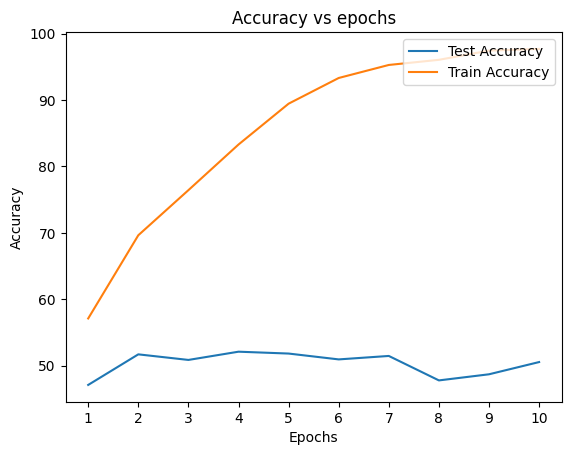

In [ ]:
epochs = np.arange(1,11)
plt.xticks(epochs, epochs)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs epochs")
plt.plot(epochs,test_accs,label="Test Accuracy")
plt.plot(epochs,train_accs,label="Train Accuracy")
plt.legend(loc = "upper right")
